# Attack Classifier

This project will apply machine learning classification to the problem of attributing terrorist attacks to perpetrators. The Global Terrorism Database (GTD) contains many events that lack a definitive attribution. Machine learning should be able to use attack attributes to predict with varying degrees of confidence which group perpetrated these unattributed attacks. The ACLED database has many fewer unattributed events, and thus should provide a reasonable amount of validation.

In [1]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd

In [4]:
gtd = pd.read_csv('../data/globalterrorismdb_0919dist.csv')

In [5]:
gtd.head()

,Unnamed: 0,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [6]:
gtd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191464 entries, 0 to 191463
Columns: 136 entries, Unnamed: 0 to related
dtypes: float64(53), int64(25), object(58)
memory usage: 198.7+ MB


In [7]:
gtd['iyear'].max()

2018

In [8]:
gtd['country_txt'].value_counts()

Iraq                   26057
Pakistan               14847
Afghanistan            14509
India                  12853
Colombia                8515
                       ...  
South Vietnam              1
International              1
Andorra                    1
St. Lucia                  1
Antigua and Barbuda        1
Name: country_txt, Length: 205, dtype: int64

In [9]:
gtd[gtd['country_txt'] == 'Iraq']['gname'].value_counts()

Unknown                                        19233
Islamic State of Iraq and the Levant (ISIL)     5486
Al-Qaida in Iraq                                 632
Islamic State of Iraq (ISI)                      145
Asa'ib Ahl al-Haqq                                71
                                               ...  
Anbar Salvation Council                            1
Jihadist Soldiers                                  1
Ansar al-Jihad                                     1
Kurdish Peshmerga Guerrillas                       1
Barzani Guerrillas                                 1
Name: gname, Length: 102, dtype: int64

In [10]:
gtd[gtd['country_txt'] == 'Afghanistan']['gname'].nunique()

45

In [11]:
gtd[gtd['country_txt'] == 'Afghanistan']['gname'].value_counts()

Taliban                                                                                 8671
Unknown                                                                                 5220
Khorasan Chapter of the Islamic State                                                    357
Haqqani Network                                                                           85
Hizb-I-Islami                                                                             42
Al-Qaida                                                                                  20
Tehrik-i-Taliban Pakistan (TTP)                                                           15
Gunmen                                                                                     9
Afghan Guerrillas                                                                          7
Afghan Mujahideen                                                                          7
Guerrillas                                                            

Afghanistan seems like a suitable choice. There is a large number of events for training the model. The number of classes is more manageable than many countries with lots of attacks.

# Afghanistan

## Create Testing Set of Unattributed Attacks

First we'll extract the unknown and generic perpetrators to serve as a testing set.

In [12]:
# the Afghan Mujahideen are a boderline case - they seem to have had some amount of organization during the Soviet invasion
afg_generic = [
    'Unknown',
    'Gunmen',
    'Afghan Guerrillas',
    'Guerrillas',
    'Opposition Group',
    'Militants',
    'Insurgents',
    'Muslim extremists',
    'Muslim Militants',
    'Islamist extremists',
    'Muslim Guerrillas',
    'Anti-United States extremists',
    'Afghan Rebels',
    'Shia Muslim extremists'
]

afg_test = gtd[(gtd['country_txt'] == 'Afghanistan') & (gtd['gname'].isin(afg_generic))]

afg_test.head()

,Unnamed: 0,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
7627,7627,197902140010,1979,2,14,NaN,0,NaN,4,Afghanistan,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
9156,9156,197908270005,1979,8,27,NaN,0,NaN,4,Afghanistan,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN
9218,9218,197909090001,1979,9,9,NaN,0,NaN,4,Afghanistan,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,-9,-9,NaN
33929,33929,198803270001,1988,3,27,NaN,0,NaN,4,Afghanistan,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
34063,34063,198804100009,1988,4,10,NaN,0,NaN,4,Afghanistan,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN


In [13]:
afg_test.shape

(5269, 136)

<AxesSubplot:>

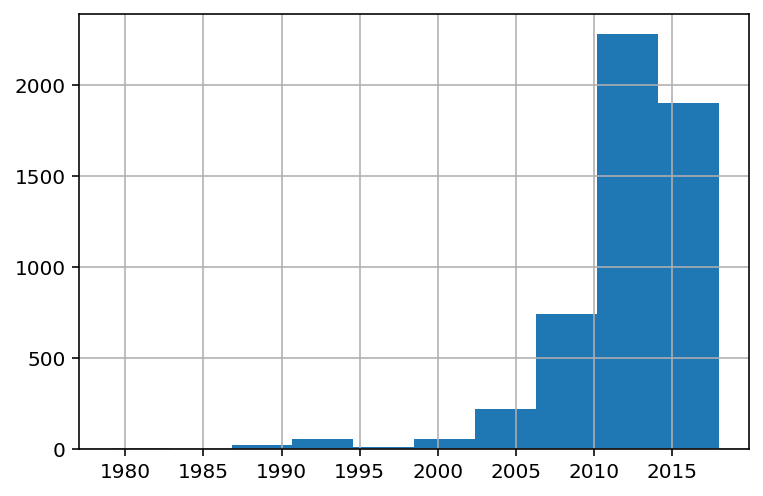

In [15]:
afg_test['iyear'].hist()

In [16]:
(afg_test['iyear'] > 2016).value_counts()

False    4473
True      796
Name: iyear, dtype: int64

There are 796 events that could potentially appear in ACLED, which covers Afghanistan for the period 2017-present. That seems like a reasonable sample size for external validation.

## Construct Training and Validation Sets

In [17]:
# extract Afg events that are not in the generic list
afg_X = gtd[(gtd['country_txt'] == 'Afghanistan') & ~(gtd['gname'].isin(afg_generic))]

afg_X.shape

(9240, 136)

We have a significant class imbalance problem:

In [18]:
afg_X['gname'].value_counts()

Taliban                                                                                 8671
Khorasan Chapter of the Islamic State                                                    357
Haqqani Network                                                                           85
Hizb-I-Islami                                                                             42
Al-Qaida                                                                                  20
Tehrik-i-Taliban Pakistan (TTP)                                                           15
Afghan Mujahideen                                                                          7
The Northern Alliance (or United Islamic Front for Salvation of Afghanistan - UIFSA)       5
Mahaz Fedai Tahrik Islami Afghanistan                                                      5
Hezb-e Wahdat-e Islami-yi Afghanistan                                                      5
Jamiat-e Islami-yi Afghanistan                                        

Potential solutions include:
- Combining categories
- 